---
title: IBV Victoria and Yamagata Phylogenetic Tree Reconstruction
author: Elgin Akin
date: 2024-05-06
---

The purpose of this notebook is to record the step to curate influneza B sequences for phylogenetic tree reconstruction. 
The following reference sequences were added to provide additional context to timetree reconstruction: 

Vaccine Strains:
* B/Brisbane/60/2008
* B/Phuket/3073/2013
* B/Austria/

Parental Strains:
* B/Lee/40 
* Yamagata 88-like
* Victoria 88-like

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:

# Define the directory where your file is located
directory_path = '/Users/elgin/Library/CloudStorage/OneDrive-JohnsHopkins/01_Pekosz_Lab/10_manuscript_reviews/20231115_IBV-Review/20231018_2015-2023-WholeGenomeIBV-VicYam-combined'

# Set the working directory
os.chdir(directory_path)

# remove duplicates from both vic and yam
rmdup by name

In [ ]:
mkdir resuults/rmdup

seqkit \
rmdup -n \
data/vic/gisaid_epiflu_sequence.fasta \
> results/vic_gisaid_epiflu_sequence_rmdup.fasta

seqkit \
rmdup -n \
data/yam/gisaid_epiflu_sequence.fasta \
> results/yam_gisaid_epiflu_sequence_rmdup.fasta

In [ ]:
# Split sequences by segment
mkdir results/pyflute/vic
python scripts/pyflute.py -i results/vic_gisaid_epiflu_sequence_rmdup.fasta -o results/pyflute/vic

mkdir results/pyflute/yam
python scripts/pyflute.py -i results/yam_gisaid_epiflu_sequence_rmdup.fasta -o results/pyflute/yam

# Generate metadata from fasta headers

In [ ]:
# victoria
augur parse \
--sequences ./results/pyflute/vic/HA.fasta \
--output-sequences ./results/augur/vic/ha/vic_filtered.fasta \
--output-metadata ./results/augur/vic/ha/vic_metadata.tsv \
--fields strain strain_name date segment

In [ ]:
# yamagata
augur parse \
--sequences ./results/pyflute/yam/HA.fasta \
--output-sequences ./results/augur/yam/ha/yam_filtered.fasta \
--output-metadata ./results/augur/yam/ha/yam_metadata.tsv \
--fields strain strain_name date segment

# Call fasta quality and clades for each lineage

In [ ]:
#download nextclade dataset
nextclade dataset get -n flu_vic_ha -o config/nextclade/flu_vic_ha
nextclade dataset get -n flu_yam_ha -o config/nextclade/flu_yam_ha

In [ ]:
# victoria seqs
nextclade run \
    --input-dataset=config/nextclade/flu_vic_ha/ \
    --output-all=results/nextclade/vic/ha/ \
    results/augur/vic/ha/vic_filtered.fasta

In [ ]:
# yamagata seqs
nextclade run \
    --input-dataset=config/nextclade/flu_yam_ha/ \
    --output-all=results/nextclade/yam/ha/ \
    results/augur/yam/ha/yam_filtered.fasta

# Add lineage and clade information to metadata files and concatenate

In [ ]:
# make directory for concatenated file results
mkdir results/cat

In [19]:
import pandas as pd

# define input file names
input_vic_meta = 'results/augur/vic/ha/vic_metadata.tsv'
input_vic_nextclade ='results/nextclade/vic/ha/nextclade.tsv'
input_yam_meta = 'results/augur/yam/ha/yam_metadata.tsv'
input_yam_nextclade ='results/nextclade/yam/ha/nextclade.tsv'

#import augur parse and nextclade metadata
vic_meta = pd.read_csv(input_vic_meta, sep="\t")
vic_nextclade = pd.read_csv(input_vic_nextclade, sep="\t")
yam_meta = pd.read_csv(input_yam_meta, sep="\t")
yam_nextclade = pd.read_csv(input_yam_nextclade, sep="\t")

# add lineage information
vic_meta['lineage'] = 'victoria'
yam_meta['lineage'] = 'yamagata'

# left join nextclade data to augur parse metadata

vic_meta = pd.merge(vic_meta, vic_nextclade, left_on="strain", right_on="seqName", how="left")
yam_meta = pd.merge(yam_meta, yam_nextclade, left_on="strain", right_on="seqName", how="left")

# concat both lineages together
metadata = pd.concat([vic_meta, yam_meta])

# drop seqname and nextclade index columns
# Drop index and seqName columns from merged DataFrame
metadata.drop(columns=['index', 'seqName'], inplace=True)

# write out concatenated metadata
metadata.to_csv('results/cat/ha_metadata.tsv', sep='\t', index=False)


/var/folders/j6/0p8zbk917z1f9lhzhhqms65h0000gn/T/ipykernel_81928/3972310021.py:11: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  vic_nextclade = pd.read_csv(input_vic_nextclade, sep="\t")


In [20]:
# date range and histogram
import pandas as pd

# Display the range of dates
date_range = metadata['date'].min().strftime('%Y-%m-%d') + ' to ' + metadata['date'].max().strftime('%Y-%m-%d')
print('Range of Dates:', date_range)

AttributeError: 'str' object has no attribute 'strftime'

In [17]:
# concatenate fasta files
!cat results/augur/vic/ha/vic_filtered.fasta results/augur/yam/ha/yam_filtered.fasta > results/cat/ha_sequences.fasta

zsh:1: no such file or directory: results/cat/ha_sequences.fasta


# Filter GISAID awknowledgement table to reflect final downsampled isolates

In [13]:
import os

# Define the directory where your file is located
directory_path = '/Users/elgin/Library/CloudStorage/OneDrive-JohnsHopkins/01_Pekosz_Lab/10_manuscript_reviews/20231115_IBV-Review/20231018_2015-2023-WholeGenomeIBV-VicYam-combined'

# Set the working directory
os.chdir(directory_path)

working_dir = os.getcwd()
print(working_dir)

/Users/elgin/Library/CloudStorage/OneDrive-JohnsHopkins/01_Pekosz_Lab/10_manuscript_reviews/20231115_IBV-Review/20231018_2015-2023-WholeGenomeIBV-VicYam-combined


In [15]:
import pandas as pd

def extract_headers_to_df(fasta_file):
    headers = []
    with open(fasta_file, 'r') as file:
        for line in file:
            if line.startswith('>'):
                headers.append(line[1:].strip())
    
    df = pd.DataFrame(headers, columns=['Isolate_Id'])
    return df

# Example usage
fasta_file = 'results/cat/ha_filtered.fasta'
headers = extract_headers_to_df(fasta_file)
print(headers)

# To save the DataFrame to a CSV file, you can use the following line:
# df.to_csv('headers.csv', index=False)


         Isolate_Id
0    EPI_ISL_201605
1    EPI_ISL_205677
2    EPI_ISL_207263
3    EPI_ISL_211586
4    EPI_ISL_211630
..              ...
861  EPI_ISL_303047
862  EPI_ISL_212938
863   EPI_ISL_70021
864   EPI_ISL_20958
865  EPI_ISL_168822

[866 rows x 1 columns]


In [16]:
# left join GISAID metadata to extracted headers dataframe
import pandas as pd

# Load the GISAID metadata file
gisaid = pd.read_csv('data/gisaid.txt', sep='\t', encoding='ISO-8859-1')

# Display the DataFrame
print(gisaid)

             Isolate_Id                                 PB2 Segment_Id  \
0      EPI_ISL_19006802  EPI3144733|B/Catalonia/NSVH102296077_PB2/2024   
1      EPI_ISL_19006800  EPI3144717|B/Catalonia/NSVH102290712_PB2/2024   
2      EPI_ISL_19006799  EPI3144709|B/Catalonia/NSVH102290478_PB2/2024   
3      EPI_ISL_19006218                          EPI3144398|BOE154_PB2   
4      EPI_ISL_19006217                          EPI3144390|BOE148_PB2   
...                 ...                                            ...   
18608    EPI_ISL_229312             EPI807392|3000479435_N8K8H5PQ_v1_2   
18609    EPI_ISL_229311             EPI807384|3000479433_N8K8H5PG_v1_2   
18610    EPI_ISL_229310             EPI807376|3000479432_N8K8H5PB_v1_2   
18611    EPI_ISL_229309             EPI807368|3000479431_N8K8H5P6_v1_2   
18612    EPI_ISL_229308             EPI807360|3000479430_N8K8H5P1_v1_2   

                                      PB1 Segment_Id  \
0      EPI3144734|B/Catalonia/NSVH102296077_PB1/2024   

/var/folders/j6/0p8zbk917z1f9lhzhhqms65h0000gn/T/ipykernel_81928/3000994899.py:5: DtypeWarning: Columns (29,46) have mixed types. Specify dtype option on import or set low_memory=False.
  gisaid = pd.read_csv('data/gisaid.txt', sep='\t', encoding='ISO-8859-1')


In [17]:
# Perform a left join on the 'seqName' column
try:
    merged_df = pd.merge(headers, gisaid, how='left', on='Isolate_Id')
    print("DataFrames merged successfully.")
    print(merged_df.head())  # Display the first few rows of the merged DataFrame
except Exception as e:
    print(f"An error occurred while merging DataFrames: {e}")

# compare shapes to confirm
print(headers.shape)
print(gisaid.shape)
print(merged_df.shape)

# write out final gisaid table
merged_df.to_csv('gisaid_isolates.tsv', sep='\t', index=False)

DataFrames merged successfully.
       Isolate_Id                    PB2 Segment_Id  \
0  EPI_ISL_201605  EPI672140|3000413858_280945_v1_2   
1  EPI_ISL_205677  EPI686339|3025624258_281873_v1_2   
2  EPI_ISL_207263  EPI695138|3000411301_282313_v1_2   
3  EPI_ISL_211586  EPI708666|3000416677_284025_v1_2   
4  EPI_ISL_211630  EPI709014|3025624526_285013_v1_2   

                     PB1 Segment_Id                     PA Segment_Id  \
0  EPI672141|3000413858_280945_v1_1  EPI672139|3000413858_280945_v1_3   
1  EPI686340|3025624258_281873_v1_1  EPI686338|3025624258_281873_v1_3   
2  EPI695139|3000411301_282313_v1_1  EPI695137|3000411301_282313_v1_3   
3  EPI708667|3000416677_284025_v1_1  EPI708665|3000416677_284025_v1_3   
4  EPI709015|3025624526_285013_v1_1  EPI709013|3025624526_285013_v1_3   

                      HA Segment_Id                     NP Segment_Id  \
0  EPI672142|3000413858_280945_v1_4  EPI672136|3000413858_280945_v1_5   
1  EPI686342|3025624258_281873_v1_4  EPI686335|30256

# Visualize lineage sequence submission over time

## Lineage by day

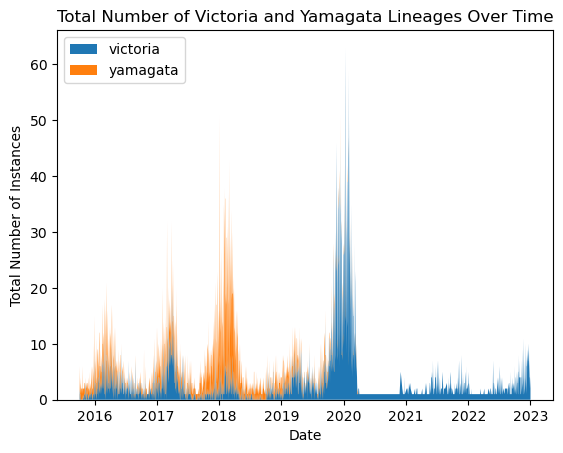

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# filter metadata for seqs between 2015 and 2023
metadata = metadata[(metadata['date'] >= '2015-01-01') & (metadata['date'] <= '2023-01-01')]

df = metadata
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by 'date' and 'lineage' and count instances
lineage_counts = df.groupby(['date', 'lineage']).size().unstack(fill_value=0)

# Plot streamgraph
plt.stackplot(lineage_counts.index, lineage_counts['victoria'], lineage_counts['yamagata'], labels=['victoria', 'yamagata'])
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Total Number of Instances')
plt.title('Total Number of Victoria and Yamagata Lineages Over Time')
plt.show()

## Lineage by month

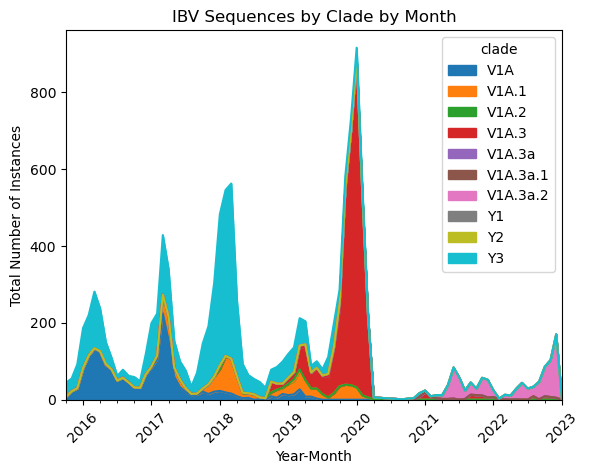

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data = metadata

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by 'year', 'month' and 'lineage' and count instances
df['year_month'] = df['date'].dt.to_period('M')
lineage_counts = df.groupby(['year_month', 'clade']).size().unstack(fill_value=0)

# Filter out rows where both lineages have zero counts
lineage_counts = lineage_counts.loc[(lineage_counts != 0).any(axis=1)]

# Plot streamgraph
lineage_counts.plot(kind='area', stacked=True)
plt.xlabel('Year-Month')
plt.ylabel('Total Number of Instances')
plt.title('IBV Sequences by Clade by Month')
plt.xticks(rotation=45)
plt.show()


## Lineage by Week

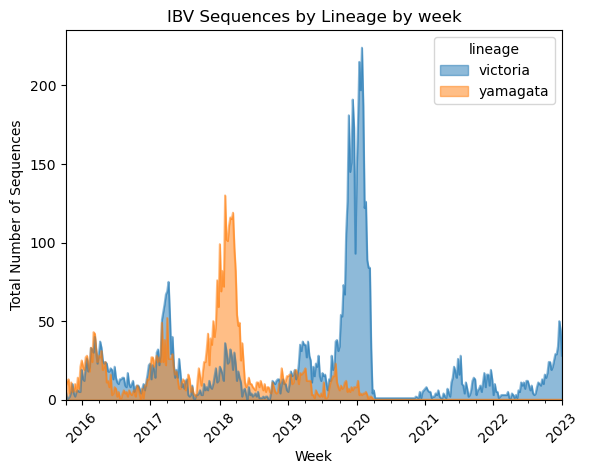

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data=metadata
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by 'week', 'lineage' and count instances
df['week'] = df['date'].dt.to_period('W')
lineage_counts = df.groupby(['week', 'lineage']).size().unstack(fill_value=0)

# Filter out rows where both lineages have zero counts
lineage_counts = lineage_counts.loc[(lineage_counts != 0).any(axis=1)]

# Plot streamgraph
lineage_counts.plot(kind='area', stacked=False)
plt.xlabel('Week')
plt.ylabel('Total Number of Sequences')
plt.title('IBV Sequences by Lineage by week')
plt.xticks(rotation=45)
plt.show()


# Downsample sequences by lineage and date

Downsampling to a total of 1000 genomes in order to lower computational burden, 
Crudely assessing the number of sequences per lineage in the downsampled dataset compared to the original dataset 

In [16]:
augur filter \
  --sequences results/cat/ha_sequences.fasta \
  --metadata results/cat/ha_metadata.tsv \
  --group-by year month \
  --subsample-max-sequences 1000 \
  --output-sequences results/cat/ha_filtered.fasta \
  --output-metadata  results/cat/ha_filtered.tsv

zsh:1: command not found: augur


## plot downsampled metadata

Reduce sequences for tree construction down to 500 sequence grouped by year and month. 

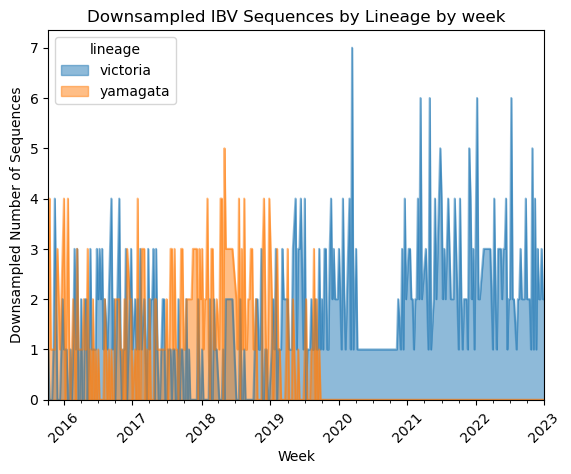

In [24]:
input_downsample_ha = 'results/cat/ha_filtered.tsv'

downsampled_ha = pd.read_csv(input_downsample_ha, sep="\t")

# filter downsampled_ha to only include sequences between 2015 and 2023
downsampled_ha = downsampled_ha[(downsampled_ha['date'] >= '2015-01-01') & (downsampled_ha['date'] <= '2023-01-01')]

down_df=downsampled_ha
# Convert 'date' column to datetime format
down_df['date'] = pd.to_datetime(down_df['date'])

# Group by 'week', 'lineage' and count instances
down_df['week'] = down_df['date'].dt.to_period('W')
lineage_counts = down_df.groupby(['week', 'lineage']).size().unstack(fill_value=0)

# Filter out rows where both lineages have zero counts
lineage_counts = lineage_counts.loc[(lineage_counts != 0).any(axis=1)]

# Plot streamgraph
lineage_counts.plot(kind='area', stacked=False)
plt.xlabel('Week')
plt.ylabel('Downsampled Number of Sequences')
plt.title('Downsampled IBV Sequences by Lineage by week')
plt.xticks(rotation=45)
plt.show()


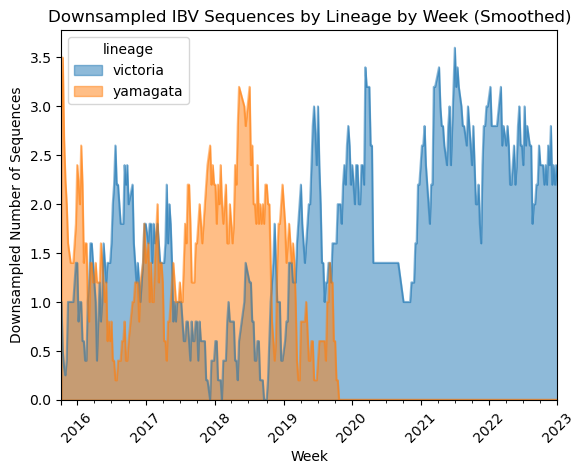

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the downsampled data
input_downsample_ha = 'results/cat/ha_filtered.tsv'
downsampled_ha = pd.read_csv(input_downsample_ha, sep="\t")

# Filter downsampled_ha to only include sequences between 2015 and 2023
downsampled_ha = downsampled_ha[(downsampled_ha['date'] >= '2015-01-01') & (downsampled_ha['date'] <= '2023-01-01')]

# Convert 'date' column to datetime format
downsampled_ha['date'] = pd.to_datetime(downsampled_ha['date'])

# Group by 'week', 'lineage' and count instances
downsampled_ha['week'] = downsampled_ha['date'].dt.to_period('W')
lineage_counts = downsampled_ha.groupby(['week', 'lineage']).size().unstack(fill_value=0)

# Filter out rows where both lineages have zero counts
lineage_counts = lineage_counts.loc[(lineage_counts != 0).any(axis=1)]

# Smooth the curves using a rolling average
smoothed_counts = lineage_counts.rolling(window=5, min_periods=1).mean()

# Plot smoothed streamgraph
smoothed_counts.plot(kind='area', stacked=False)
plt.xlabel('Week')
plt.ylabel('Downsampled Number of Sequences')
plt.title('Downsampled IBV Sequences by Lineage by Week (Smoothed)')
plt.xticks(rotation=45)
plt.show()


# tree construction

In [ ]:
# align using augur align
augur align \
  --sequences results/cat/ha_filtered.fasta \
  --reference-sequence config/genome_annotation.gb \
  --remove-reference \
  --output results/cat/ha_filtered.aln \
  --fill-gaps


In [ ]:
treetime \
    --dates results/cat/ha_filtered.tsv \
    --aln results/cat/ha_filtered.aln \
    --reroot oldest \
    --outdir results/cat/ha_treetime

Proceed with visualization of the tree in the `02_tree_plots.qmd` notebook.